Primero importamos las librerías necesarias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
#from scikitplot.metrics import plot_lift_curve,plot_cumulative_gain #!pip install scikit-plot
import warnings
warnings.filterwarnings("ignore")

Ahora importe los datos para guardarlos como un "Data frame" y poder usarlos aquí en el Notebook. Primero debe dar click a la celda de abajo que se encuentra vacía. Luego abra el panel derecho dando click en el siguiente ícono que se encuentra arriba a la derecha:

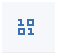

Después que cargue deberá ver los archivos csv que previamente a cardagos. Busque "Churn_Modeling.csv", de click en "Insert to code" y luego "Insert pandas DataFrame"

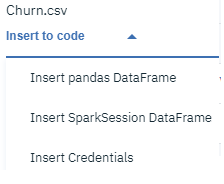


Asegurate de que el data frame creado tenga el  nombre df_data_1, de lo contrario corrigelo.

Corre la celda.




El problema de taza de abandono de un banco tiene la particularidad de que del total de clientes solo un pequeño porcentaje es el que abandona el banco. En otras palabas, la variable "Exited" tiene muchos más "0" que "1". Para observar este comportamiento observemos la siguiente gráfica.

In [ ]:
#Gráfica de variable a predecir
churn_count=sns.countplot(df_data_1.Exited)
churn_count.set(xlabel="¿El cliente abandonó el banco?",ylabel="Número de clientes",title="Distribución del abandono")
plt.show()

print('Taza de abandono = ',str(100*sum(df_data_1.Exited==1)/len(df_data_1.Exited))+"%")

Ahora se van a hacer los últimos paso de procesamiento de datos. Primero debemos separar los datos en las
matrices X,y. En "X" se guardan todas las variables que se van a usar para poder predecir y en "y"se guarda
la variable "Exited" que es la que queremos predecir. 

Los aloritmos de machine learning no entienden bien cuando las variables son texto (Como es el caso de las variables "Geography" y "Gender". Para esto se usa una técnica llamada "Label encoding" que consiste en transformar cada palabra única de las variables a un número. Por ejemplo, en la variable "Geography" se podría convertir France a 1 y Spain a 2. 

Finalmente, se separan los datos en dos conjuntos: uno de entrenamiento y otro de prueba.

In [ ]:
##Se crean las matrices X,y.
X=df_data_1.drop('Exited',axis=1)#Eliminamos columnas
y=df_data_1.Exited#Definimos variable a predecir


##Se define función que crea diccionarios para transformar los factores de las variables categóricas a números y viceversa.
def label_encoder(X,cols):
    from collections import namedtuple
    encode={}
    decode={}
    for i in cols:
        le=LabelEncoder()
        le.fit_transform(X[i])
        encode[i]=dict(zip(le.classes_, le.transform(le.classes_)))
        decode[i]=dict(zip(le.transform(le.classes_),le.classes_))
    encoder_tuple = namedtuple('encoder_tuple', ['encode', 'decode'])
    dictionaries=encoder_tuple(encode,decode)
    return(dictionaries)


categoric=X.select_dtypes(include=['object']).columns#Guarda el nombre de las columnas categóricas.

dictionaries=label_encoder(X,categoric)#Label encoder dictionaries
X.replace(dictionaries.encode,inplace=True)#Codificamos las variables categóricas.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=0)#Dividimos los datos en entrenamiento y prueba.

m,n=X_train.shape#Extraemos las dimensiones de la matriz X de entrenamiento.

X.head()#Observamos cómo quedan las primeras 5 filas luego de la transformación.

En esta sección se corre el algoritmo que determinará el modelo.

Los modelos de machine learning requieren de ciertos parámetros que el usuario debe ingresar. Sin embargo, hacer esto a mano no es nada práctico por lo que existen diferentes métodos para "automatizar" el proceso.
El método usado a continuación se llama "búsqueda aleatoria". Para esto simplemente se seleccionan los parámetros que se quieren sintonizar y se establecen rangos de valores en los que se quieren que estén los parámetros. El valor que toma cada variable es tomado aleatoriamente de este este rango en cada iteración.

Finalmente, se calcula la exactitud de los diferentes modelos y se escogen los parámetros del modelo con mejor exactitud.

In [ ]:
param_dist = {"max_features": sp_randint(int(np.sqrt(n)), int(3*n/4)),
              "min_samples_leaf": sp_randint(1, 20)}#Se definen los hiperparámetros para sintonizar el modelo

clf= RandomForestClassifier(n_jobs=-1,n_estimators=#COLOCAR AQUÍ NÚMERO DE ÁRBOLES ) #Se inicializa la instancia de Random Forest.

#Corre búsqueda aleatorio por X iteraciones.
n_iter_search = #COLOQUE AQUÍ EL NÚMERO DE ITERACIONES
random_search_clf= RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,cv=5,scoring="accuracy",random_state=10)

random_search_clf.fit(X_train, y_train)#Se entrena el modelo con los mejores parámetros encontrados.

best_estimator=random_search_clf.best_estimator_#Guarda el modelo.
best_score=random_search_clf.best_score_#Guarda el puntaje del mejor modelo

print(' Best params:',best_estimator,'\n','Best score:',best_score)

Ya que el modelo está entrenado, procedemos a probarlo en el conjunto de prueba.
Para esto realizamos las predicciones de estos datos y luego comparamos con los resultados reales.
Esta comparación se hace de acuerdo a varias métricas.

In [ ]:
y_pred=best_estimator.predict(X_test)#Predicciones binarias en el conjunto de prueba
y_pred_proba=best_estimator.predict_proba(X_test)#Predicciones de probabilidad en el conjunto de prueba

accuracy=accuracy_score(y_pred=y_pred,y_true=y_test)#Exactitud
AUC=roc_auc_score(y_score=y_pred_proba[:,1],y_true=y_test)#AUC
average_precision_score=  average_precision_score(y_true=y_test,y_score=y_pred_proba[:,1])

print('Accuracy:'+str(np.round(accuracy*100,4))+"%","\t",'AUC:'+str(np.round(AUC*100,4))+"%","\t"
     ,'average_precision_score:'+str(np.round(average_precision_score*100,4))+"%","\t")

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------

# Crear un API del modelo

Se importan los respositorios de machine learning.

In [ ]:
from ibm_watson_machine_learning import APIClient


Para acceder a Watson Machine Learning, debe crear una APIKEY. Hay dos formas de hacer esto: a través de la cli de IBM Cloud o mediante la interfaz de IBM Cloud.

Si desea crear una APIKEY a través de API, primero descargue, instale IBM Cloud CLI. Una vez instalado, ejecute los siguientes comandos para obtener APIKEY

inicio de sesión de ibmcloud
ibmcloud iam api-key-create API_KEY_NAME

A través de la interfaz, simplemente haga clic en Administrar y luego en Acceso (IAM) como se muestra en la imagen a continuación.


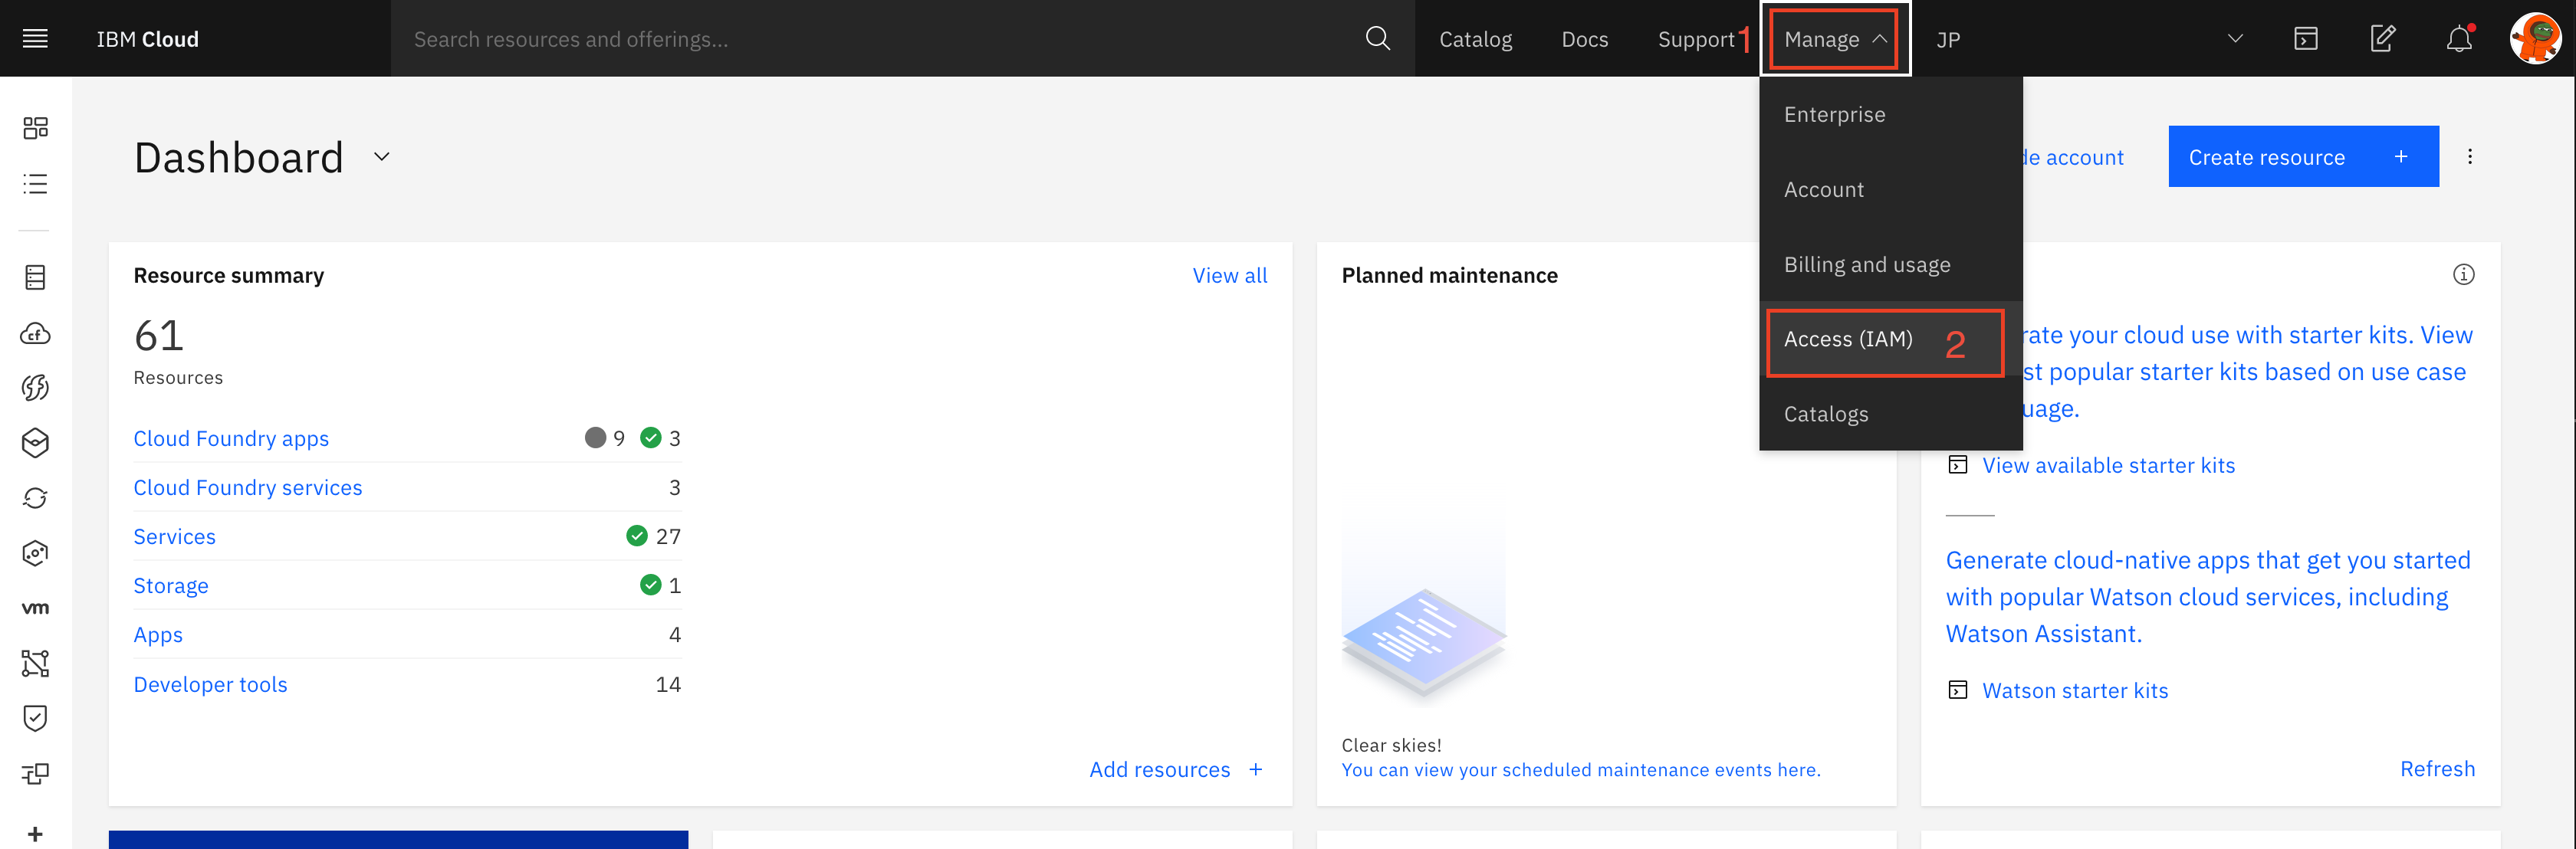

Tan pronto como se carga la página, en el lado izquierdo hay un menú. Haga clic en las claves de API para crear una nueva, como se muestra en la imagen a continuación.

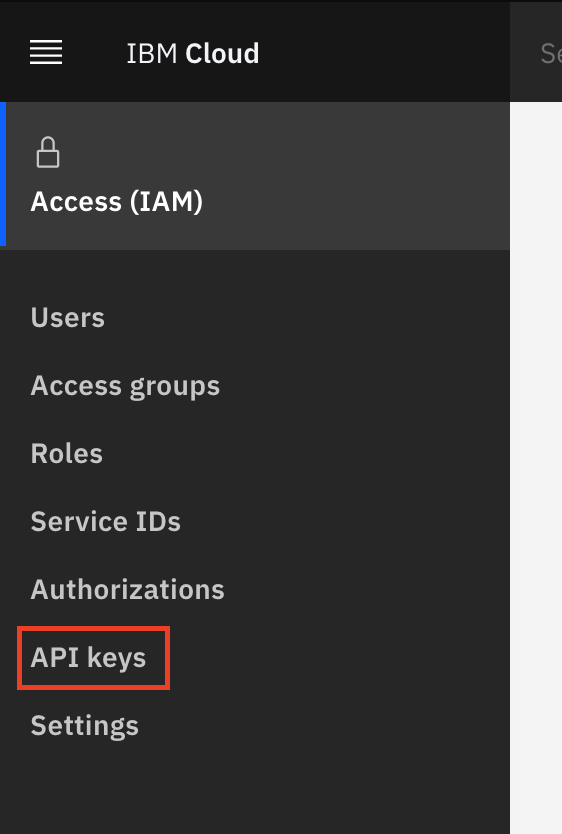

La siguiente imagen muestra un panel con todas sus API creadas para la plataforma IBM Cloud, creemos uno nuevo accediendo al servicio WML haciendo clic en Crear una clave API de IBM Cloud

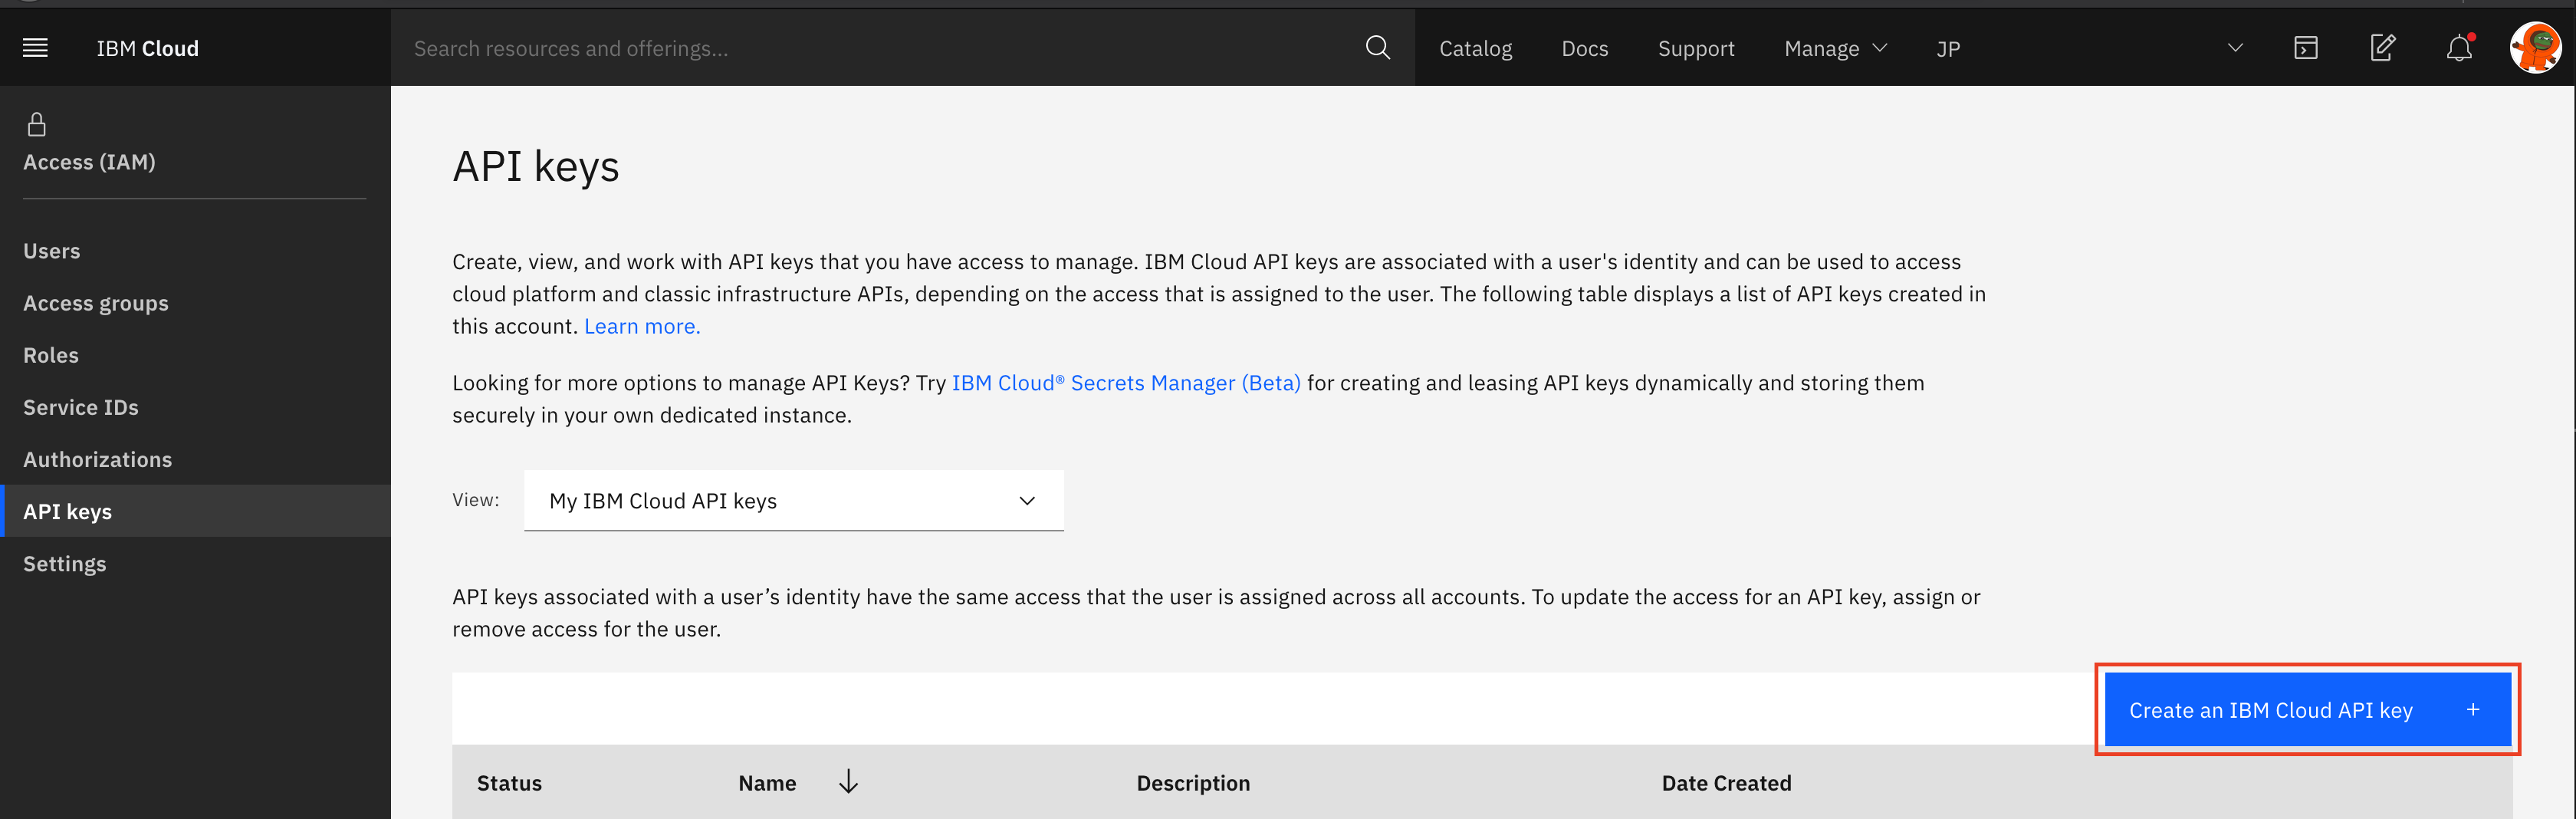

Se abrirá un formulario donde simplemente nombre su API y haga clic en Crear. Tan pronto como haga clic en el botón, se creará su API y simplemente cópiela, insértela en apikey en la celda de abajo.

Además de necesitar una APIKEY para acceder a Watson Machine Learning, necesitamos saber la URL donde se encuentra, así que tenga en cuenta al crear el servicio en qué región lo está instanciando. Cada región tiene una URL específica y se enumeran a continuación.

* Dallas: https://us-south.ml.cloud.ibm.com
* London: https://eu-gb.ml.cloud.ibm.com
* Frankfurt: https://eu-de.ml.cloud.ibm.com
* Tokyo: https://jp-tok.ml.cloud.ibm.com

Con el WML ubicado correctamente, ingrese la URL correcta en la celda a continuación.

In [ ]:
wml_credentials = {
  "apikey": "YOUR_WML_APIKEY",
  "url": "URL_REGION_OF_YOUR_WML"
}

print(wml_credentials)

Se autentica el servicio con las credenciales.

In [ ]:
client = APIClient(wml_credentials)

Guardamos el modelo en la instancia del servicio de machine learning

## Preparando el ambiente que recibirá el modelo


Watson Machine Learning organiza el despliegue de modelos en espacios, de manera que es posible utilizar la instancia WML de la organización y dividirla en pequeños espacios dedicados a alojar los modelos que cada departamento construirá y pondrá a disposición. Por tanto, luego de instanciar el WML, es necesario crear un espacio para recibir el modelo que vamos a crear. Para crear un espacio en WML, debemos volver a la pantalla de inicio de Cloud Pak 4 Data y hacer clic en Implementaciones, ubicado en el lado izquierdo, como se muestra en la imagen a continuación.

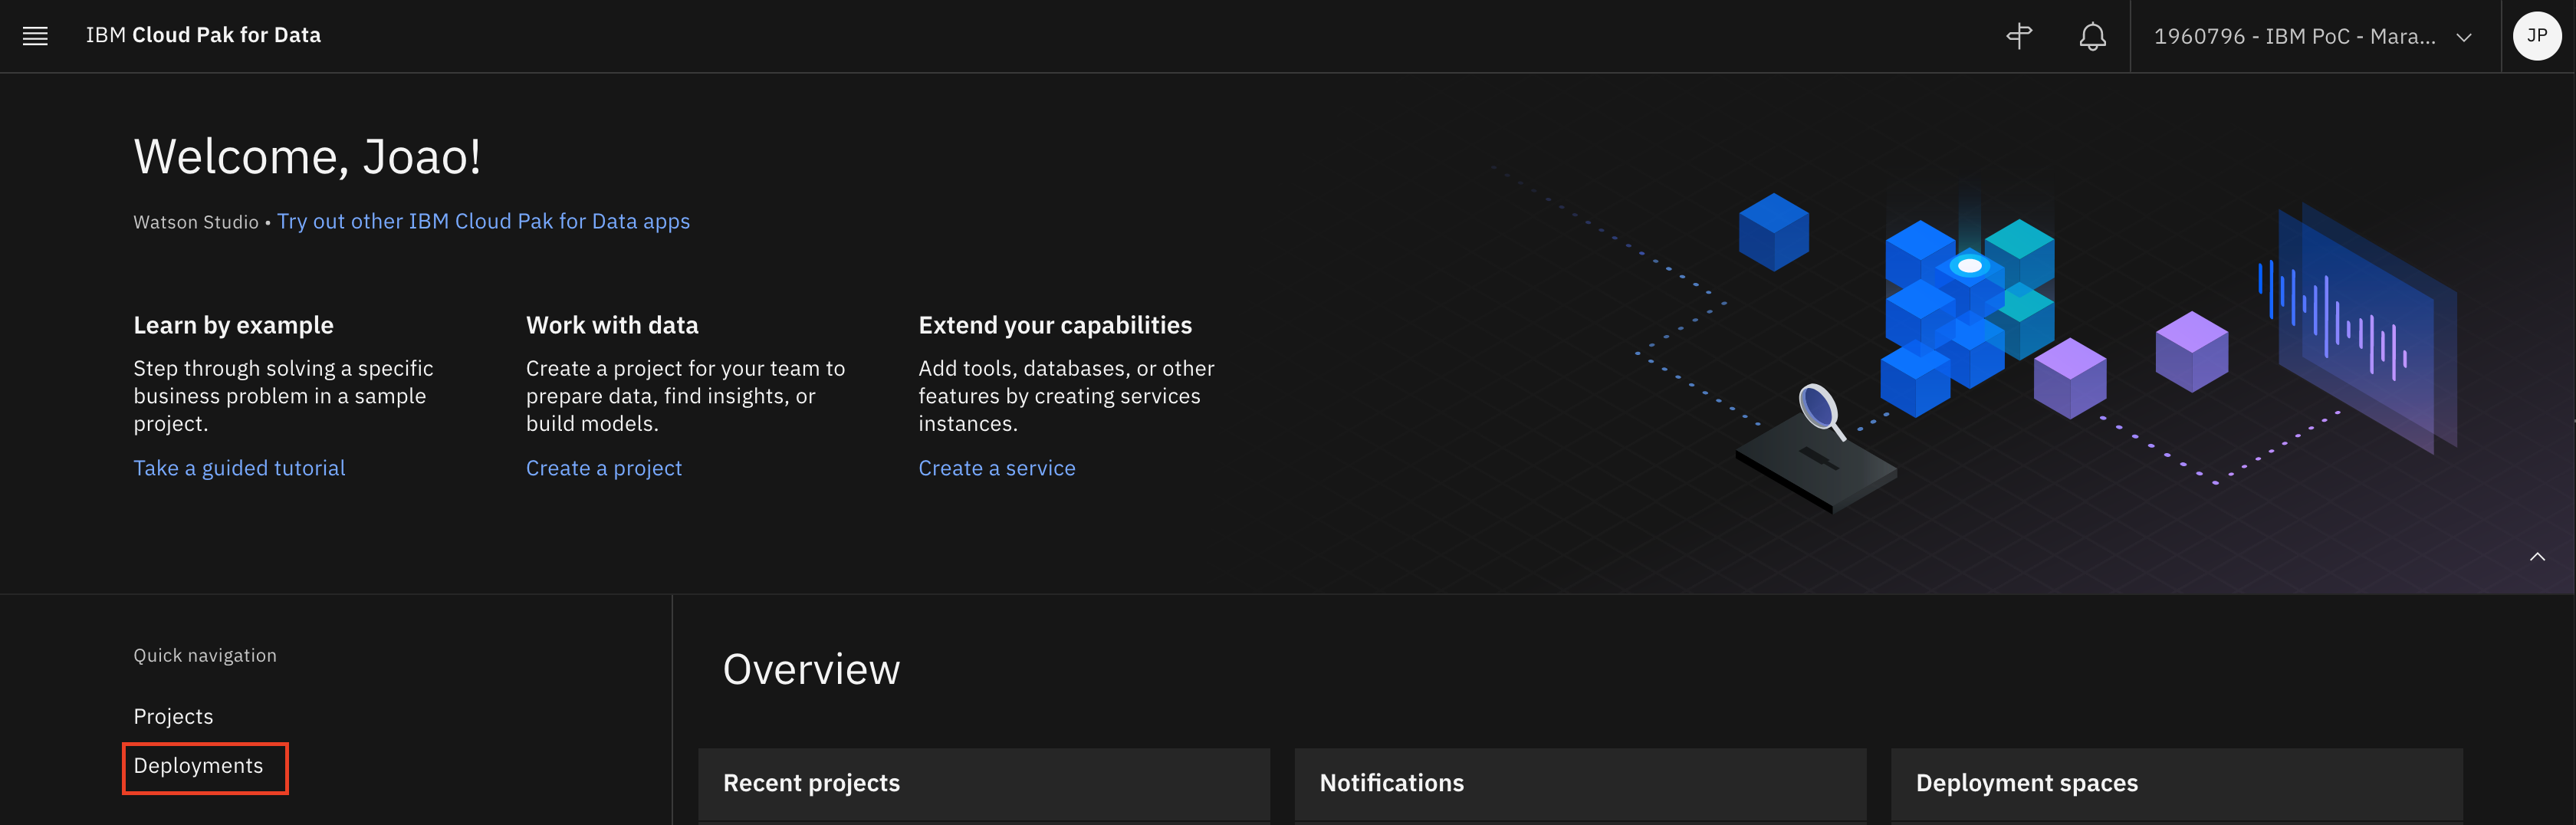

Tan pronto como se carga la página, estamos dentro de la interfaz de implementación que constituye un acceso directo a Watson Machine Learning. Ahora hagamos clic en el botón de espacio de implementación para crear un nuevo espacio, como se muestra en la imagen a continuación.

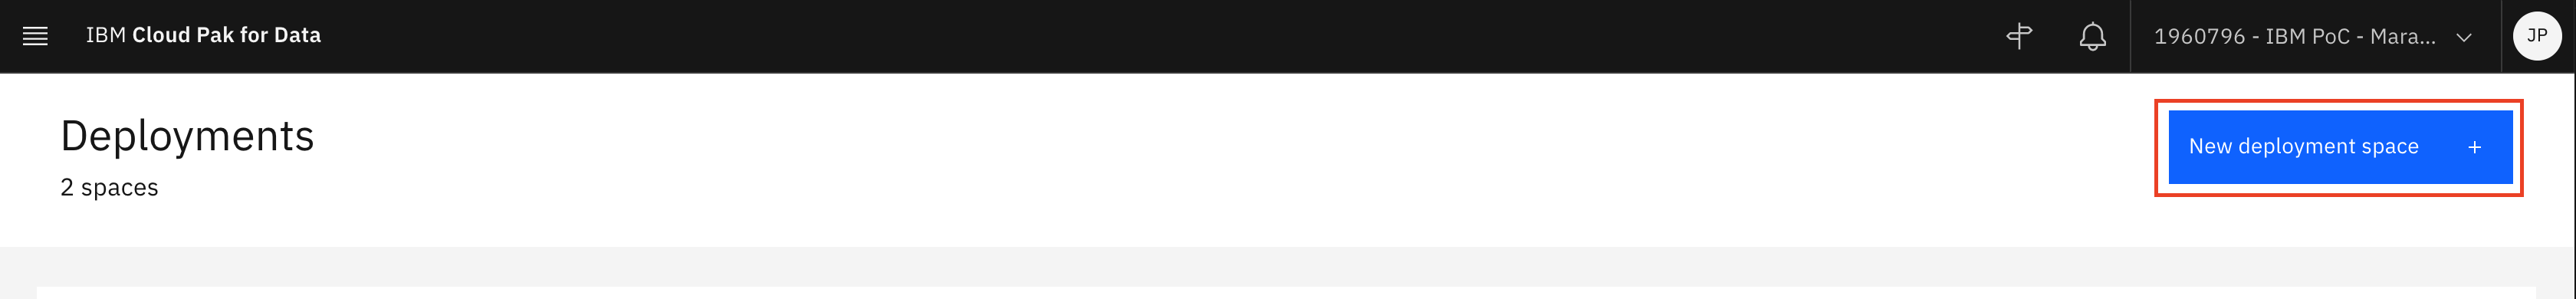

Creemos un espacio vacío para recibir nuestro modelo, como se muestra en la imagen de abajo.

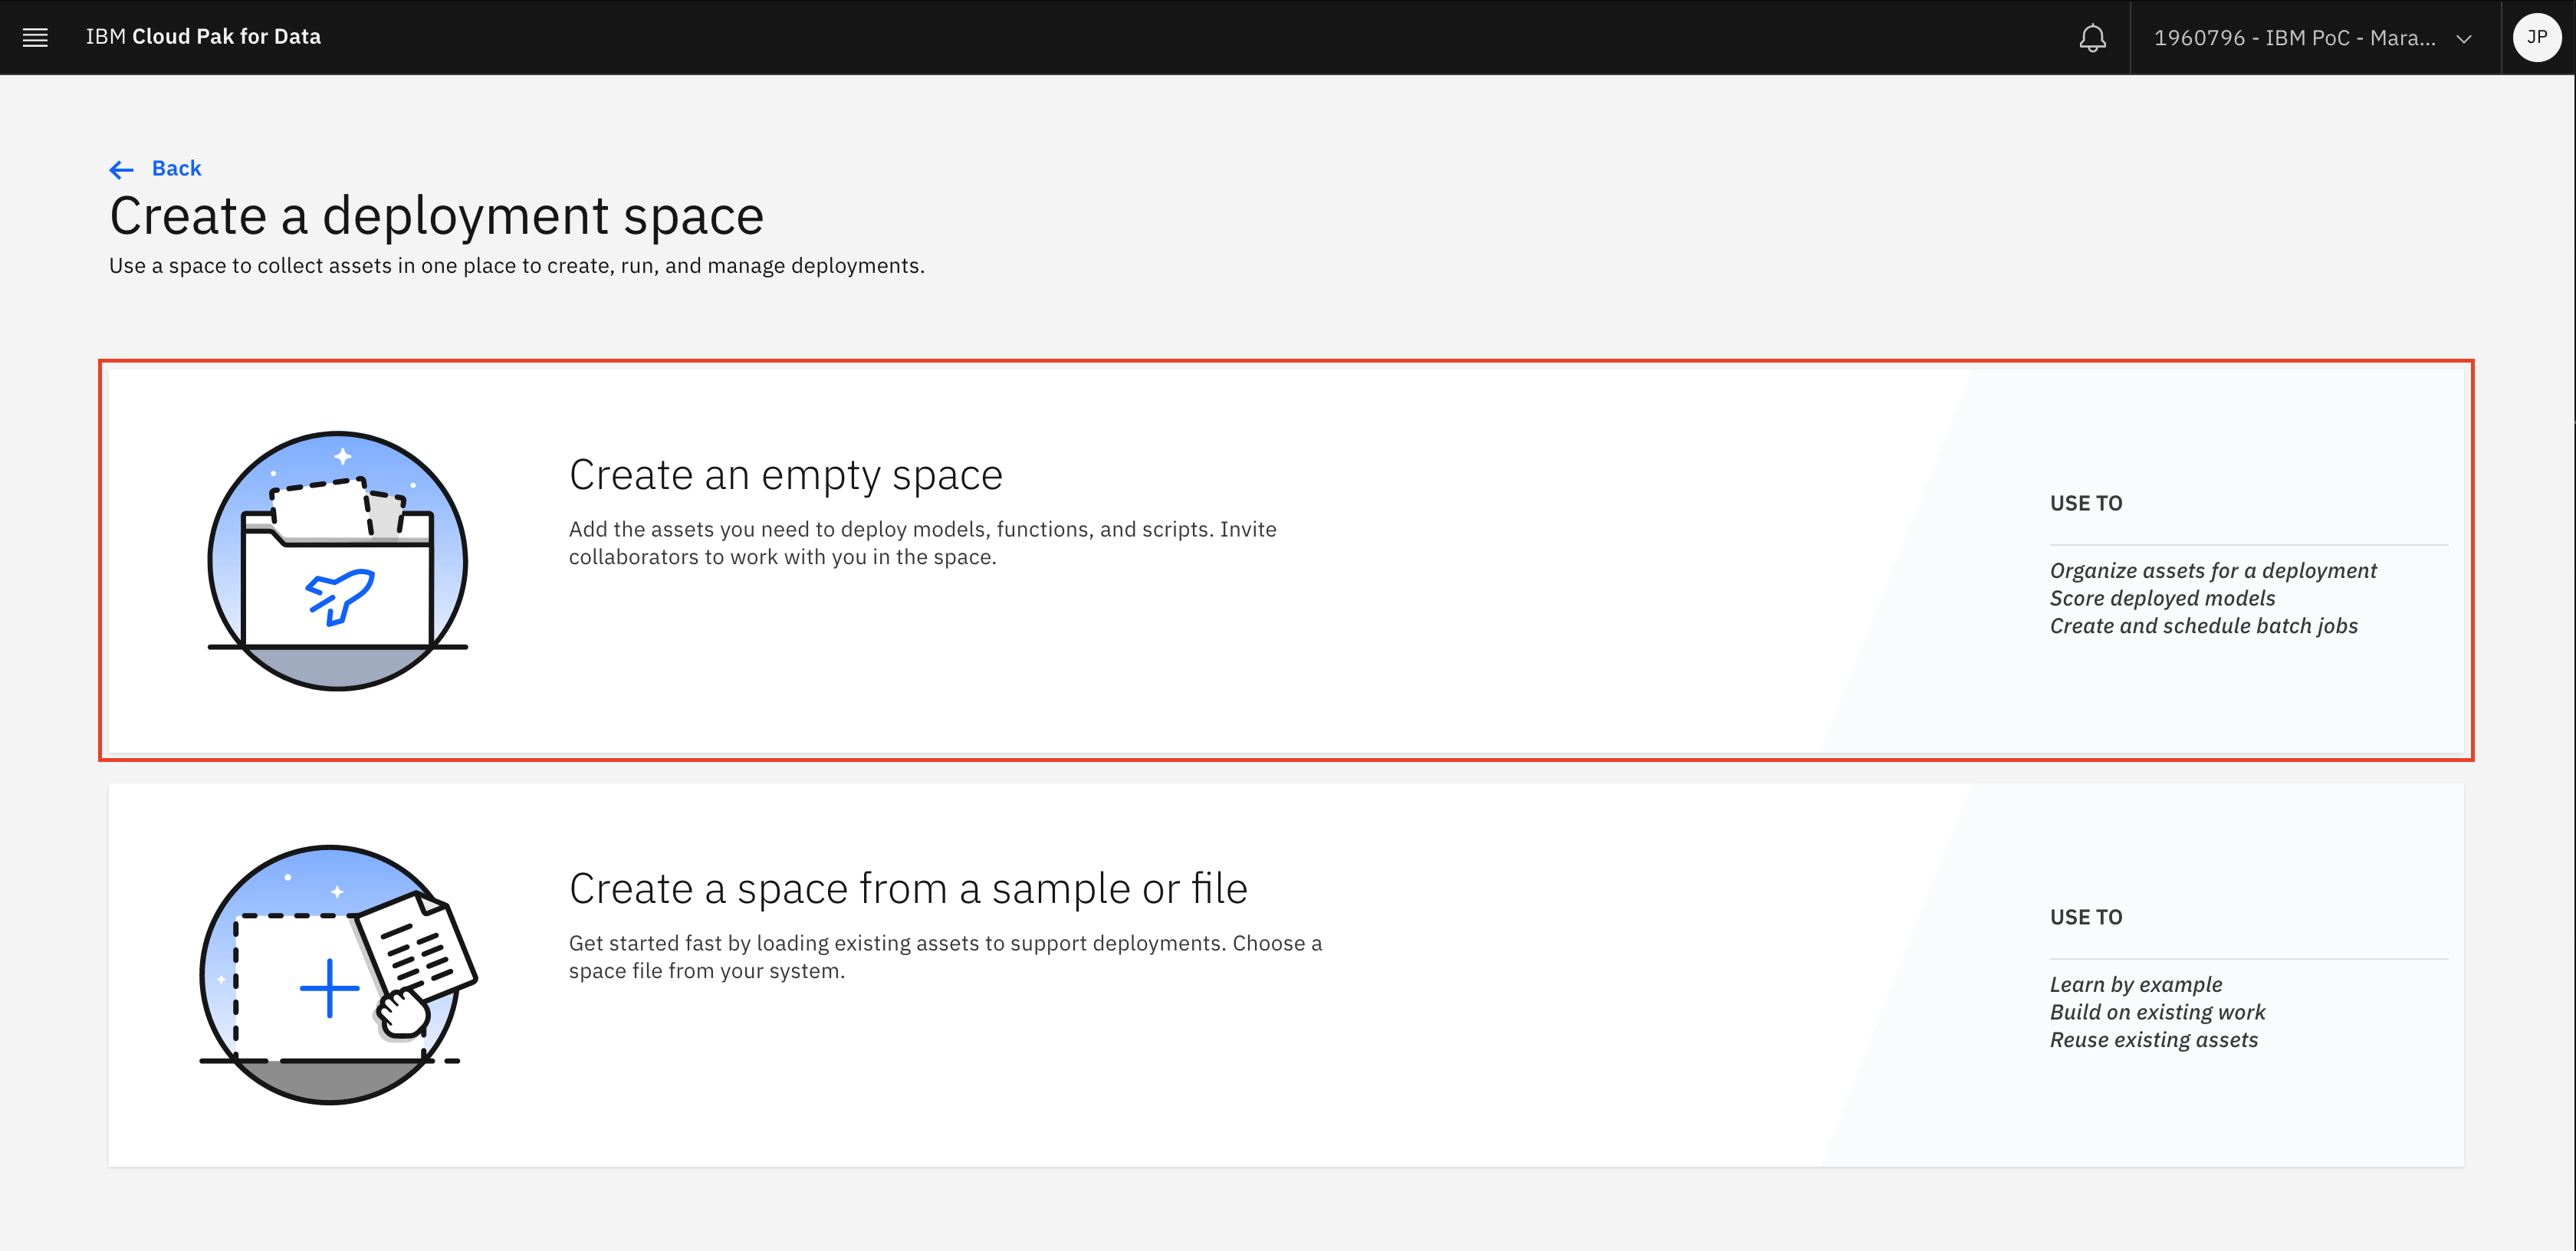

Debemos completar alguna información ahora. Necesitamos darle un nombre al espacio, asociar un almacenamiento de objetos y Watson Machine Learning al espacio. Con el formulario completado, simplemente haga clic en el botón Crear ubicado en la esquina inferior derecha.

Con el espacio creado, podemos desplegar el modelo creado y proceder con la ejecución de las celdas de este notebook.


In [ ]:
client.spaces.list(limit=10)


In [ ]:
space_id = 'YOUR_SPACE_ID'

In [ ]:
client.set.default_space(space_id)

In [ ]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")

In [ ]:
metadata = {
            client.repository.ModelMetaNames.NAME: 'Churn Notebook 37',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
             client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=best_estimator,
    meta_props=metadata)

In [ ]:
client.repository.list_models()

In [ ]:
import json
saved_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(saved_model_uid)
print(json.dumps(model_details, indent=2))

# Despliegue del modelo

In [ ]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Churn Notebook Dply",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(client.repository.get_model_uid(published_model), meta_props=metadata)

# Scoring Endpoint

Ahora podemos acceder al REST API del modelo desplegado

In [ ]:
deployment_uid = client.deployments.get_uid(created_deployment)


In [ ]:
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

Ahora podemos realizar el llamado online del modelo publicado

# Scoring del modelo

Ahora vamos a probar el modelo con datos de prueba ingresados por ustedes. Corra la siguiente celda y llene las celdas que se le solicitan
que son necesarias para realizar la predicción. Esta celda guarda estos valores y los pre-procesa para que pueda ser usado por el modelo. Se genera un JSON que será la entrada al modelo.

In [ ]:
Credit_score=int(input("Credit score: "))
Geography=input("Geography: ")
Gender=input("Gender: ")
Age=int(input("Age: "))
Tenure=int(input("Tenure: "))
Balance=int(input("Balance: "))
Num_products=int(input("Number of products: "))
HasCrCard=input("Has credit card: ")
IsActiveMember=input("Is active member: ")
EstimadedSalary=int(input("Estimated salary"))



new_observation=np.array([[Credit_score,Geography,Gender,Age,Tenure,Balance,Num_products,HasCrCard,IsActiveMember,EstimadedSalary]],dtype=object)
new_observation=pd.DataFrame(new_observation,columns=X.columns)
new_observation.replace(dictionaries.encode,inplace=True)

#Revisar la implementacion del API en el modelo desplegado en nuestro Proyecto.

scoring_payload = {
    "input_data": [{
        'fields': ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"],
        'values': [list(new_observation.values[0])]}]
}

print(scoring_payload)

Al correr la celda de abajo se está ingresando el JSON anteriormente generado y se está haciendo el request a la API.

In [ ]:
response_scoring = client.deployments.score(deployment_uid, scoring_payload)

probabilidad_abandono=response_scoring['predictions'][0]['values'][0][1][1]
print("Este cliente tiene una probabilidad de",np.round(probabilidad_abandono,2),"de abandonar el banco")